In [690]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

Loading Data and Summary Statistics 

In [691]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [692]:
#summary for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [693]:
#summary for categegorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Data Preparation - Cleaning and Transformation

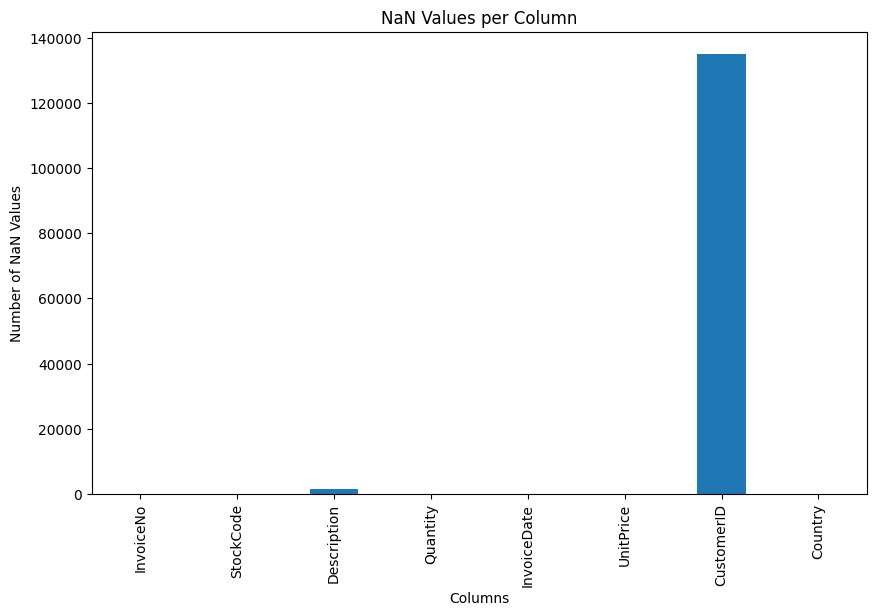

In [694]:
#Handling missing values
nan_counts = df.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6), title='NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

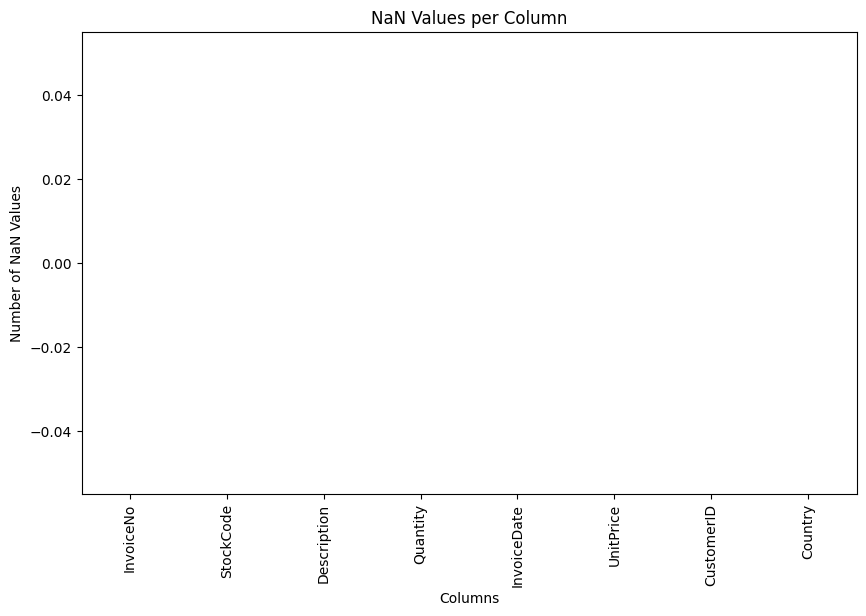

In [695]:
#drop missing values and verify that such rows have been dropped
df.dropna(inplace=True)
nan_counts = df.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6), title='NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

In [696]:
#Handling duplicates
duplicated_rows = df[df.duplicated()]
duplicated_rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [697]:
df.drop_duplicates(inplace=True)

In [698]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


EDA

In [699]:
# #Stockcode anomalies
# import matplotlib.pyplot as plt

# # Calculate the length of each Stockcode value
# # Calculate the length of each Stockcode value
# stockcode_lengths = df['StockCode'].str.len()

# # Count the occurrences of each unique length
# length_counts = stockcode_lengths.value_counts().reset_index()
# length_counts.columns = ['Length', 'Count']

# # Sort by length for better presentation
# length_counts = length_counts.sort_values(by='Length')

# # Display the table
# print(length_counts)


In [700]:
# df[df['StockCode']=="POST"]


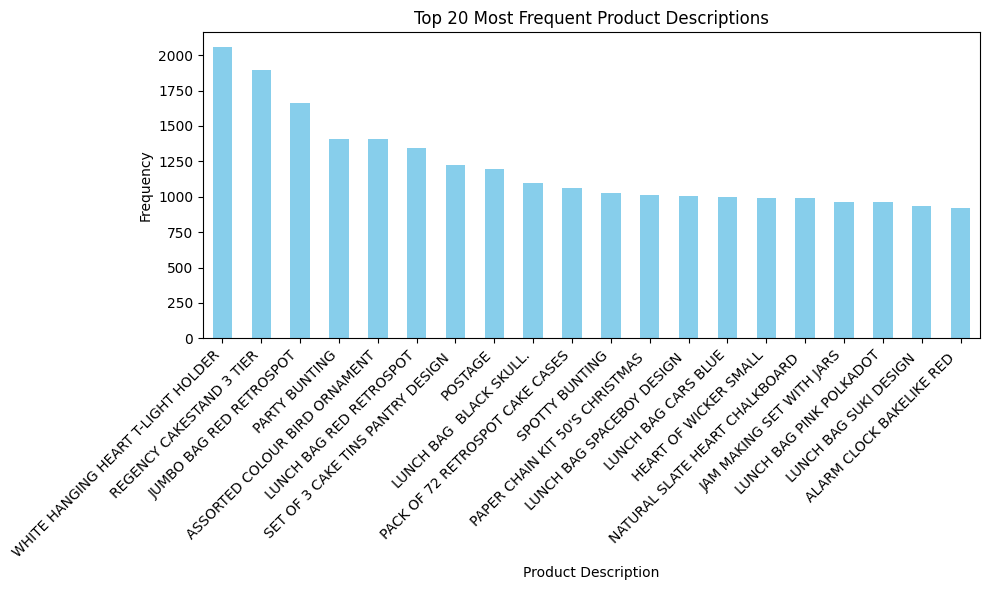

In [701]:
#EDA for Discription 
# Get the top 20 most frequent values in the product descriptions column
top_20_descriptions = df['Description'].value_counts().head(20)

# Plot the top 20 most frequent values
plt.figure(figsize=(10, 6))
top_20_descriptions.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Product Descriptions')
plt.xlabel('Product Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [702]:
#Investigating UnitPrice Discrepancies
df['UnitPrice'].describe()

count    401604.000000
mean          3.474064
std          69.764035
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [703]:
df.loc[df['UnitPrice'] > 1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45622,C540271,M,Manual,-1,1/6/2011 11:51,1126.00,12503.0,Spain
73446,C542348,M,Manual,-1,1/27/2011 12:09,1715.85,12539.0,Spain
117052,C546325,M,Manual,-1,3/11/2011 10:15,1687.17,14911.0,EIRE
117053,C546327,M,Manual,-1,3/11/2011 10:18,1687.17,14911.0,EIRE
117054,546328,M,Manual,1,3/11/2011 10:19,1687.17,14911.0,EIRE
117055,546329,M,Manual,1,3/11/2011 10:22,1687.17,14911.0,EIRE
144826,548813,M,Manual,1,4/4/2011 13:03,2382.92,12744.0,Singapore
144828,548813,M,Manual,1,4/4/2011 13:03,1252.95,12744.0,Singapore
144829,548820,M,Manual,1,4/4/2011 13:04,2053.07,12744.0,Singapore
144831,C548830,M,Manual,-1,4/4/2011 13:08,2382.92,12744.0,Singapore


In [704]:
##MIGHT USE TO EVENTUALLY DROP ROWS WITH USELESS DESCRIPTIONS
# lowercase_descriptions = df['Description'].unique()
# lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# # Print the unique descriptions containing lowercase characters
# print("The unique descriptions containing lowercase characters are:")
# print("-"*60)
# for desc in lowercase_descriptions:
#     print(desc)

In [705]:
#Investigating anomalies in StockCode, as shown above, stockcodes usually contain numeric values, however, all the rows with extreme values contain only alphabets in stockcode
no_numeric_mask = ~df['StockCode'].str.contains(r'\d')

# Use the boolean mask to filter the DataFrame
rows_with_no_numeric = df[no_numeric_mask]

rows_with_no_numeric['StockCode'].unique()


array(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [706]:
df = df[df['StockCode'].str.contains(r'\d')]

In [707]:
df['UnitPrice'].describe()

count    399823.000000
mean          2.923285
std           4.537682
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [708]:
#check if there are any exisiting columns with unitprice 0
df[df['UnitPrice']==0]
df = df[df['UnitPrice'] != 0]


In [709]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399790 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    399790 non-null  object 
 1   StockCode    399790 non-null  object 
 2   Description  399790 non-null  object 
 3   Quantity     399790 non-null  int64  
 4   InvoiceDate  399790 non-null  object 
 5   UnitPrice    399790 non-null  float64
 6   CustomerID   399790 non-null  float64
 7   Country      399790 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.5+ MB


In [710]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [711]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [712]:
earliest = df['InvoiceDate'].min()
earliest

Timestamp('2010-12-01 08:26:00')

In [713]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [714]:
date_format = df['InvoiceDate'].dt.strftime('%Y-%m-%d %H:%M:%S').iloc[0]

print("Date Format:", date_format)

Date Format: 2010-12-01 08:26:00


In [715]:
three_months = earliest + pd.DateOffset(months=3)

In [716]:
q1 = df[(df['InvoiceDate'] >= earliest) & (df['InvoiceDate'] <= three_months)]
q1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
105329,545218,85099B,JUMBO BAG RED RETROSPOT,10,2011-02-28 17:01:00,1.95,17462.0,United Kingdom
105330,545218,21936,RED RETROSPOT PICNIC BAG,5,2011-02-28 17:01:00,2.95,17462.0,United Kingdom
105331,545218,21932,SCANDINAVIAN PAISLEY PICNIC BAG,5,2011-02-28 17:01:00,2.95,17462.0,United Kingdom
105332,545218,22386,JUMBO BAG PINK POLKADOT,10,2011-02-28 17:01:00,1.95,17462.0,United Kingdom


In [717]:
state_df = pd.DataFrame(q1['CustomerID'].unique(), columns=['CustomerID'])
state_df['Q1'] = 'Active'

In [718]:
six_months = earliest + pd.DateOffset(months=6)
q2 = df[(df['InvoiceDate'] >= three_months) & (df['InvoiceDate'] <= six_months)]
q2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom
105336,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom
...,...,...,...,...,...,...,...,...
209034,555157,47590A,BLUE HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
209035,555157,22849,BREAD BIN DINER STYLE MINT,1,2011-06-01 07:38:00,16.95,15643.0,United Kingdom
209036,555157,47566,PARTY BUNTING,8,2011-06-01 07:38:00,4.95,15643.0,United Kingdom
209037,555157,82580,BATHROOM METAL SIGN,12,2011-06-01 07:38:00,0.55,15643.0,United Kingdom


In [719]:
q2 = pd.DataFrame(q2['CustomerID'].unique(), columns=['CustomerID'])
q2['Q2'] ='Active'

In [720]:
state_df = pd.merge(state_df, q2, how='left', on='CustomerID')
state_df['Q2'].fillna('Warm', inplace=True)
state_df

,CustomerID,Q1,Q2
0,17850.0,Active,Warm
1,13047.0,Active,Active
2,12583.0,Active,Active
3,13748.0,Active,Active
4,15100.0,Active,Warm
...,...,...,...
1740,15656.0,Active,Active
1741,12811.0,Active,Active
1742,16518.0,Active,Active
1743,17165.0,Active,Warm


In [721]:
q2['Q1'] = 'NA'
state_df = pd.concat([state_df, q2]).reset_index(drop=True)
state_df = state_df.drop_duplicates(subset=['CustomerID'], keep='first')
state_df

,CustomerID,Q1,Q2
0,17850.0,Active,Warm
1,13047.0,Active,Active
2,12583.0,Active,Active
3,13748.0,Active,Active
4,15100.0,Active,Warm
...,...,...,...
3761,13070.0,NA,Active
3762,14819.0,NA,Active
3763,12790.0,NA,Active
3765,15163.0,NA,Active


In [722]:
nine_months = earliest + pd.DateOffset(months=9)
q3 = df[(df['InvoiceDate'] >= six_months) & (df['InvoiceDate'] <= nine_months)]
q3 = pd.DataFrame(q3['CustomerID'].unique(), columns=['CustomerID'])
q3['Q3'] ='Active'
q3

,CustomerID,Q3
0,14842.0,Active
1,15124.0,Active
2,14646.0,Active
3,12423.0,Active
4,12473.0,Active
...,...,...
1978,17777.0,Active
1979,15582.0,Active
1980,16780.0,Active
1981,16278.0,Active


In [723]:
state_df = pd.merge(state_df, q3, how='left', on='CustomerID')

In [724]:
state_df.fillna('NA', inplace=True)
state_df

,CustomerID,Q1,Q2,Q3
0,17850.0,Active,Warm,NA
1,13047.0,Active,Active,Active
2,12583.0,Active,Active,Active
3,13748.0,Active,Active,NA
4,15100.0,Active,Warm,NA
...,...,...,...,...
2756,13070.0,NA,Active,NA
2757,14819.0,NA,Active,NA
2758,12790.0,NA,Active,NA
2759,15163.0,NA,Active,NA


In [725]:
state_df.loc[(state_df['Q2'] == 'Active') & (state_df['Q3'] == 'NA'), 'Q3'] = 'Warm'
state_df.loc[(state_df['Q2'] == 'Warm') & (state_df['Q3'] == 'NA'), 'Q3'] = 'Cold'

In [726]:
state_df

,CustomerID,Q1,Q2,Q3
0,17850.0,Active,Warm,Cold
1,13047.0,Active,Active,Active
2,12583.0,Active,Active,Active
3,13748.0,Active,Active,Warm
4,15100.0,Active,Warm,Cold
...,...,...,...,...
2756,13070.0,NA,Active,Warm
2757,14819.0,NA,Active,Warm
2758,12790.0,NA,Active,Warm
2759,15163.0,NA,Active,Warm


In [727]:
q3[['Q1', 'Q2']] = "NA"
state_df = pd.concat([state_df, q3]).reset_index(drop=True)
state_df = state_df.drop_duplicates(subset=['CustomerID'], keep='first')
state_df

,CustomerID,Q1,Q2,Q3
0,17850.0,Active,Warm,Cold
1,13047.0,Active,Active,Active
2,12583.0,Active,Active,Active
3,13748.0,Active,Active,Warm
4,15100.0,Active,Warm,Cold
...,...,...,...,...
4732,14660.0,NA,NA,Active
4735,13726.0,NA,NA,Active
4737,15690.0,NA,NA,Active
4739,17777.0,NA,NA,Active


In [728]:
q4 = df[df['InvoiceDate'] >= nine_months]
q4 = pd.DataFrame(q4['CustomerID'].unique(), columns=['CustomerID'])
q4['Q4'] ='Active'
q4

,CustomerID,Q4
0,13305.0,Active
1,16187.0,Active
2,17306.0,Active
3,12474.0,Active
4,13631.0,Active
...,...,...
2984,15898.0,Active
2985,13404.0,Active
2986,13077.0,Active
2987,16446.0,Active


In [729]:
state_df = pd.merge(state_df, q4, how='left', on='CustomerID')
state_df.fillna('NA', inplace=True)
state_df.loc[(state_df['Q3'] == 'Active') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Warm'
state_df.loc[(state_df['Q3'] == 'Warm') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Cold'
state_df.loc[(state_df['Q3'] == 'Cold') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Inactive'
state_df

,CustomerID,Q1,Q2,Q3,Q4
0,17850.0,Active,Warm,Cold,Inactive
1,13047.0,Active,Active,Active,Active
2,12583.0,Active,Active,Active,Active
3,13748.0,Active,Active,Warm,Active
4,15100.0,Active,Warm,Cold,Inactive
...,...,...,...,...,...
3344,14660.0,NA,NA,Active,Active
3345,13726.0,NA,NA,Active,Active
3346,15690.0,NA,NA,Active,Active
3347,17777.0,NA,NA,Active,Active


In [730]:
q4[['Q1', 'Q2', 'Q3']] = 'NA'
state_df = pd.concat([state_df, q4]).reset_index(drop=True)
state_df = state_df.drop_duplicates(subset=['CustomerID'], keep='first')

In [731]:
state_df.reset_index(drop=True, inplace=True)
state_df

,CustomerID,Q1,Q2,Q3,Q4
0,17850.0,Active,Warm,Cold,Inactive
1,13047.0,Active,Active,Active,Active
2,12583.0,Active,Active,Active,Active
3,13748.0,Active,Active,Warm,Active
4,15100.0,Active,Warm,Cold,Inactive
...,...,...,...,...,...
4357,13436.0,NA,NA,NA,Active
4358,15520.0,NA,NA,NA,Active
4359,13298.0,NA,NA,NA,Active
4360,14569.0,NA,NA,NA,Active


In [732]:
# find active to active prob
active_to_active = []
active_to_active.append(len(state_df[(state_df['Q2'] == 'Active') & (state_df['Q1'] == 'Active')]) / len(state_df[state_df['Q1'] == 'Active']))
active_to_active.append(len(state_df[(state_df['Q3'] == 'Active') & (state_df['Q2'] == 'Active')]) / len(state_df[state_df['Q2'] == 'Active']))
active_to_active.append(len(state_df[(state_df['Q4'] == 'Active') & (state_df['Q3'] == 'Active')]) / len(state_df[state_df['Q3'] == 'Active']))
active_to_active = np.mean(active_to_active)
active_to_active

0.6216458073476977

In [733]:
# find active to warm prob
active_to_warm = []
active_to_warm.append(len(state_df[(state_df['Q2'] == 'Warm') & (state_df['Q1'] == 'Active')]) / len(state_df[state_df['Q1'] == 'Active']))
active_to_warm.append(len(state_df[(state_df['Q3'] == 'Warm') & (state_df['Q2'] == 'Active')]) / len(state_df[state_df['Q2'] == 'Active']))
active_to_warm.append(len(state_df[(state_df['Q4'] == 'Warm') & (state_df['Q3'] == 'Active')]) / len(state_df[state_df['Q3'] == 'Active']))
active_to_warm = np.mean(active_to_warm)
active_to_warm

0.37835419265230225

In [734]:
# find warm to active prob
warm_to_active = []
warm_to_active.append(len(state_df[(state_df['Q3'] == 'Active') & (state_df['Q2'] == 'Warm')]) / len(state_df[state_df['Q2'] == 'Warm']))
warm_to_active.append(len(state_df[(state_df['Q4'] == 'Active') & (state_df['Q3'] == 'Warm')]) / len(state_df[state_df['Q3'] == 'Warm']))
warm_to_active = np.mean(warm_to_active)
warm_to_active

0.37963865243822825

In [735]:
# find warm to cold prob
warm_to_cold = []
warm_to_cold.append(len(state_df[(state_df['Q3'] == 'Cold') & (state_df['Q2'] == 'Warm')]) / len(state_df[state_df['Q2'] == 'Warm']))
warm_to_cold.append(len(state_df[(state_df['Q4'] == 'Cold') & (state_df['Q3'] == 'Warm')]) / len(state_df[state_df['Q3'] == 'Warm']))
warm_to_cold = np.mean(warm_to_cold)
warm_to_cold

0.6203613475617717

In [736]:
# find cold to active prob
cold_to_active = len(state_df[(state_df['Q4'] == 'Active') & (state_df['Q3'] == 'Cold')]) / len(state_df[state_df['Q3'] == 'Cold'])
cold_to_active

0.3533980582524272

In [737]:
# find cold to inactive prob
cold_to_inactive = len(state_df[(state_df['Q4'] == 'Inactive') & (state_df['Q3'] == 'Cold')]) / len(state_df[state_df['Q3'] == 'Cold'])
cold_to_inactive

0.6466019417475728

In [738]:
transition_matrix = np.array([[active_to_active, active_to_warm, 0, 0],
                              [warm_to_active, 0, warm_to_cold, 0],
                              [cold_to_active, 0, 0, cold_to_inactive],
                              [0, 0, 0, 1]])
transition_matrix

array([[0.62164581, 0.37835419, 0.        , 0.        ],
       [0.37963865, 0.        , 0.62036135, 0.        ],
       [0.35339806, 0.        , 0.        , 0.64660194],
       [0.        , 0.        , 0.        , 1.        ]])